# Shape and Morphology Analysis for Overhead Image of Arabidopsis

This is a full workflow that shows methods for analyzing shape, color, and watershed segmentation analysis of plants imaged from an aerial perspective. Similar methods should work for other plant species imaged in a similar way.

# Section 1: Importing Libraries and Image

In [1]:
# Set the notebook display method
# inline = embedded plots, notebook = interactive plots
%matplotlib inline

In [18]:
# Import libraries
from plantcv import plantcv as pcv 
import numpy as np

## Input variables
The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later.

In [7]:
class options:
    def __init__(self):
        self.image = "./img/single_plant_overhead.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "aerial_morphology_results.txt"
        self.outdir = "."

In [8]:
# Get options
args = options()

# Set debug to the global parameter
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 2
pcv.params.text_thickness = 2
pcv.params.line_thickness = 10

## Read the input image

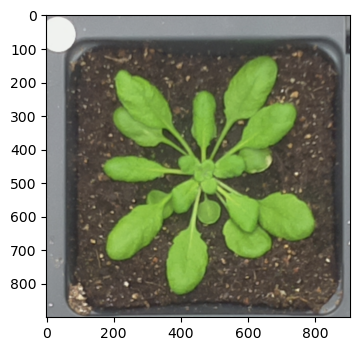

In [9]:
# Inputs:
#   filename = Image file to be read in 
#   mode     = How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

# Section 2: Isolating plant, making binary mask, getting object(s)¶
* Requires successful import of image
* See Tools for Thresholding Plant Data for a full list of functions that can be used to create a binary mask

## Visualize colorspaces

The visualization tool converts the color image into HSV and LAB colorspaces and displays the grayscale channels in a matrix so that they can be visualized simultaneously. The idea is to select a channel that maximizes the difference between the plant and the background pixels.

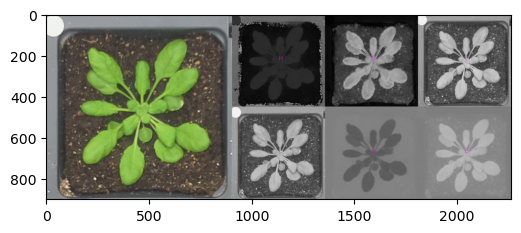

In [10]:
# Inputs:
#   rbg_img = original image
#   original_img = whether to include the original RGB images in the display: True (default) or False
colorspaces = pcv.visualize.colorspaces(rgb_img=img)

## Convert the color image to grayscale
Converts the input color image into the LAB colorspace and returns the B (blue-yellow) channel as a grayscale image.

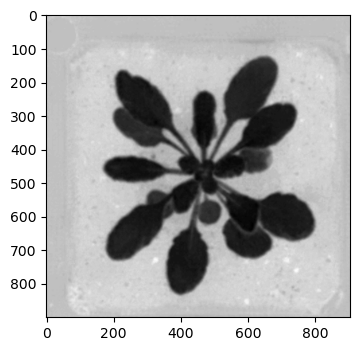

In [11]:
# Inputs:
#   rbg_img = original image
#   channel = desired colorspace ('l', 'a', or 'b')
a = pcv.rgb2gray_lab(rgb_img = img, channel = 'a')

## Visualize the distribution of grayscale values
A histogram can be used to visualize the distribution of values in an image. The histogram can aid in the selection of a threshold value.

For this image, the large peak between 120-135 are from the lighter background pixels. The smaller peaks that represent plant material are between 90-100, so we can use a threshold between 100-120 to best differentiate between plant and background pixels.

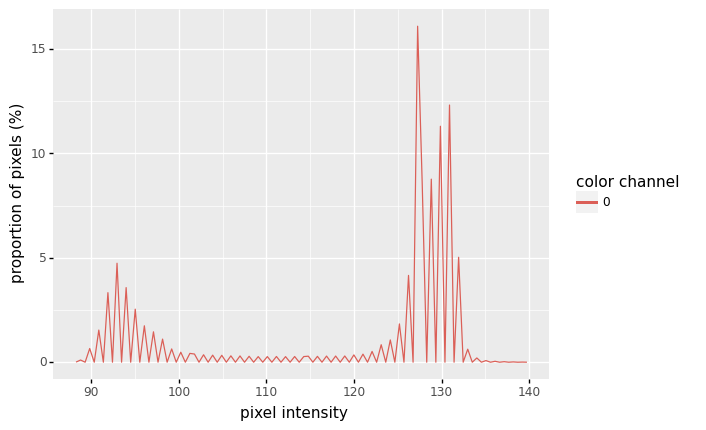

In [93]:
# Visualize histogram of colors within image

# Inputs:
#   img         = gray image in selected colorspace
#   mask        = None (default), or mask
#   bins        = 100 (default) or number of desired number of evenly spaced bins
#   lower-bound = None (default) or minimum value on x-axis
#   upper-bound = None (default) or maximum value on x-axis
#   title       = None (default) or custom plot title
#   hist_data   = False (default) or True (if frequency distribution data is desired)
hist = pcv.visualize.histogram(img=a)

## Threshold the grayscale image
Use a threshold function (binary in this case) to segment the grayscale image into plant (white) and background (black) pixels. Using the histogram above, a threshold point between 110-120 will segment the plant and background peaks. Because the plant has darker pixels in this image, use object_type="dark" to do an inverse threshold.

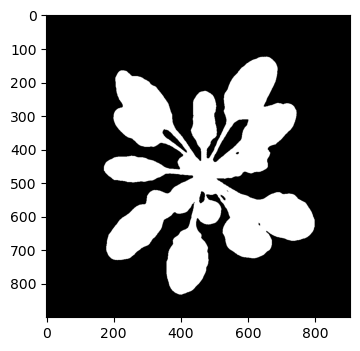

In [14]:
# Inputs:
#   gray_img    = black and white image created from selected colorspace
#   threshold   = cutoff pixel intensity value (all pixels below value will become black, all above will become white)
#   max_value   = maximum pixel value
#   object_type = 'dark' or 'light' depending on if seeds are darker or lighter than background
a_thresh = pcv.threshold.binary(gray_img=a, threshold=110, max_value=255, object_type='dark')
#                                                      ^                                 ^
#                                                      |                                 |
#                                              change this value                  change this value

# Section 3: Identify plant objects and analyze

* Requires successful binary mask

## Identify objects within image
From the binary mask, we can identify the object (plant) within the image, which can then be used later for analyses.

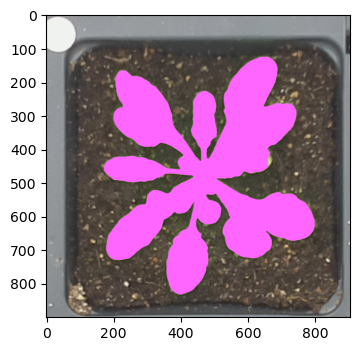

In [15]:
# Inputs:
#   img  = rgb image
#   mask = binary mask
obj, obj_hierarchy = pcv.find_objects(img = img, mask = a_thresh)

## Identify objects within a region of interest (ROI)
To eventually combine all of the objects into a singular object that identifies the plant, we need to identify a region of interest (ROI) which will either fully encapsulate or overlap with plant material. This way, if objects are identified due to "salt" noise or other background elements, they will be filtered out. In this case, since the binary mask is so clear, we can create a ROI using the binary mask. However, if there is any background noise, a geometric ROI will be better to ensure that only plant material is kept.

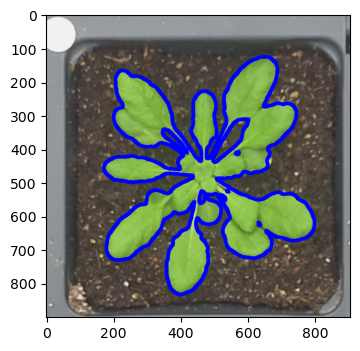

In [16]:
# Inputs:
#   img     = image
#   bin_img = binary mask for image
roi, roi_hierarchy = pcv.roi.from_binary_image(img=img, bin_img=a_thresh)

## Filter out objects that don't overlap with the ROI
Any objects that do not overlap with the ROI will be filtered out, leaving only objects that identify plant material.

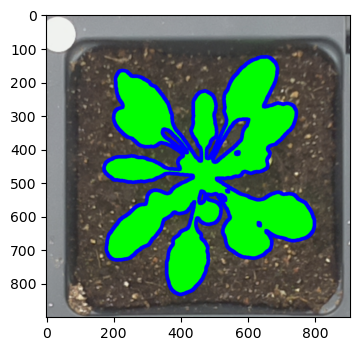

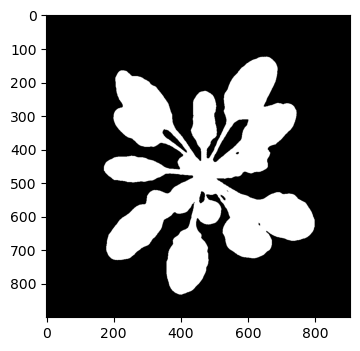

In [17]:
# Keep only objects that overlap with or are completely within the defined ROI (helps to filter out objects that do
# not contain plant material)

# Inputs:
#   img            = image
#   roi_type       = 'partial' to include objects that partially overlap with the ROI, 'cutto' to exclude any objects that 
#                     are not within the ROI, or 'largest' to keep the largest contour
#   roi_contour    = pre-defined region of interest
#   roi_hierarchy  = pre-defined roi hierarchy
#   object_contour = plant object
#   obj_hierarchy  = object hierarchy
filtered_contours, filtered_hierarchy, filtered_mask, filtered_area = pcv.roi_objects(
        img=img, roi_type="partial", roi_contour=roi, roi_hierarchy=roi_hierarchy, object_contour=obj, 
        obj_hierarchy=obj_hierarchy)

## Create an image copy

The shape analysis function returns an annotated image, so creating a copy will ensure that the original image remains unaltered.

In [19]:
# Inputs:
#   img = image
img_copy = np.copy(img)

## Combine objects

Objects kept after filtering out those not included in the ROI may still be multiple overlapping or layered objects, rather than just one. We need to combine objects so that one object, encapsulating the entire plant, can be passed to the image analysis function.

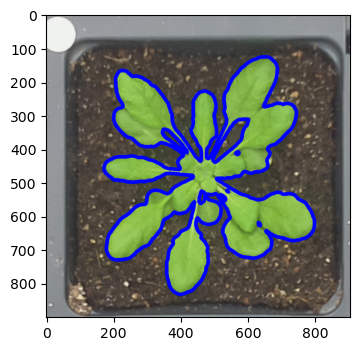

In [20]:
# Inputs:
#   img                = image
#   contours           = filtered plant contours from the roi_objects function
#   filtered_hierarchy = filtered plant contour hierarchy from the roi_objects function
plant_contour, plant_mask = pcv.object_composition(img=img, contours=filtered_contours, hierarchy=filtered_hierarchy)        


## Analyze plant shape

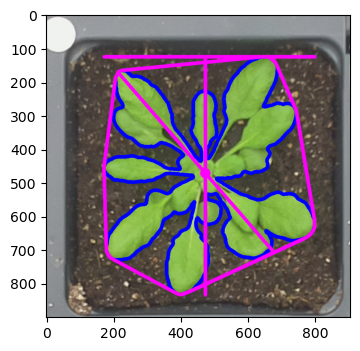

In [21]:
# Inputs:
#   img           = image (use a copy to avoid annotating the original image)
#   plant_contour = single, combined plant contour
#   mask          = single, combined binary plant mask
img_copy = pcv.analyze_object(img=img_copy, obj=plant_contour, mask=plant_mask)

## Pseudocolor grayscale image

Pseudocolor the grayscale image to a custom colormap, and optionally exclude background to focus on plant material only.

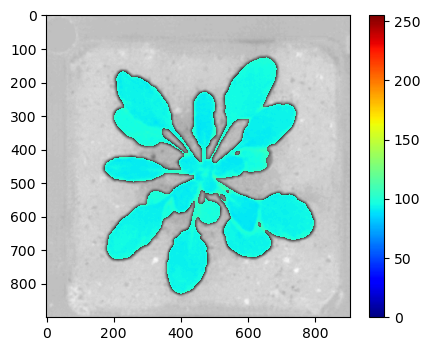

In [22]:
# Inputs:
#     gray_img   = Grayscale image data
#     obj        = Single or grouped contour object (optional), if provided the pseudocolored image gets 
#                 cropped down to the region of interest.
#     mask       = Binary mask (optional) 
#     background = Background color/type. Options are "image" (gray_img, default), "white", or "black". A mask 
#                  must be supplied.
#     cmap       = Colormap
#     min_value  = Minimum value for range of interest
#     max_value  = Maximum value for range of interest
#     dpi        = Dots per inch for image if printed out (optional, if dpi=None then the default is set to 100 dpi).
#     axes       = If False then the title, x-axis, and y-axis won't be displayed (default axes=True).
#     colorbar   = If False then the colorbar won't be displayed (default colorbar=True)
pseudocolored_img = pcv.visualize.pseudocolor(gray_img=a, mask=plant_mask, cmap='jet')

## Analyze plant color

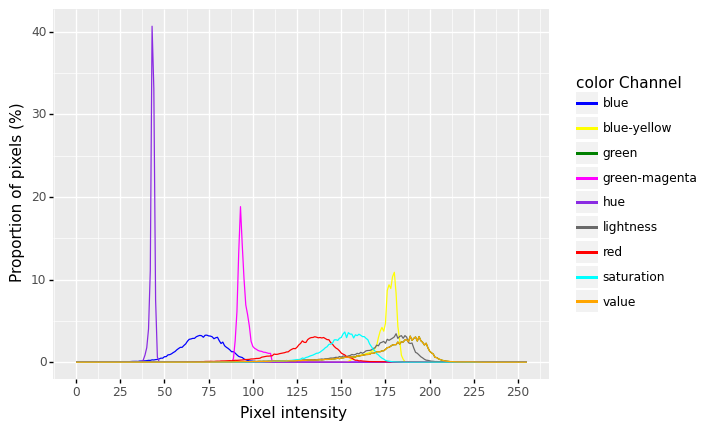

In [23]:
# Inputs:
#   img         = image
#   mask        = binary mask
#   colorspaces = 'all', 'rgb', 'lab', or 'hsv'
color_img = pcv.analyze_color(rgb_img=img, mask=a_thresh, colorspaces="all")

## Create new binary threshold

In order to look at a watershed segmentation of the plant image, which can be used to distinguish leaves, we need a
binary mask that separates leaves by using a harsher threshold. For some plants, the original binary mask may work well, but in cases when there are overlapping leaves, a new binary mask may be necessary. This may cause plant pixels to be lost, so the new mask should not be used for the other analyses shown above.


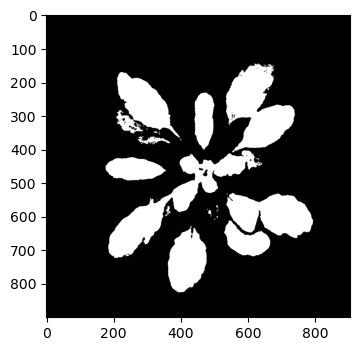

In [24]:
# Inputs:
#   gray_img    = black and white image created from selected colorspace
#   threshold   = cutoff pixel intensity value (all pixels below value will become black, all above will become white)
#   max_value   = maximum pixel value
#   object_type = 'dark' or 'light' depending on if seeds are darker or lighter than background
a_lower_thresh = pcv.threshold.binary(gray_img = a, threshold = 96, max_value = 255, object_type = 'dark')

## Watershed segmentation

Use a watershed segmentation to distinguish between leaves within an image by detecting object boundaries.

/Users/adrianethompson/Documents/REU2021/plantcv_new/plantcv/plantcv/watershed.py:46: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


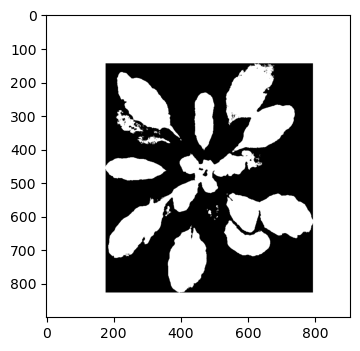

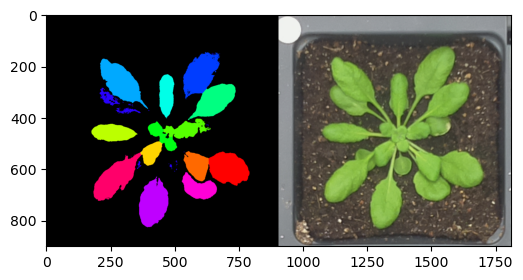

In [25]:
# Inputs:
#   rgb_img  = color image
#   mask     = binary mask
#   distance = Minimum distance of local maximum, lower values are more sensitive, and segments more objects (default=10)
#   label    = optional label (default = 'default')
watershed_analysis = pcv.watershed_segmentation(rgb_img = img, mask = a_lower_thresh, distance = 50, label = 'default')

## Save results
The save results function will take the measurements stored when running any PlantCV analysis functions, format, and print an output text file for data analysis. The Outputs class in this example will store: 'area', 'convex_hull_area', 'solidity', 'perimeter', 'width', 'height', 'longest_path', 'center_of_mass, 'convex_hull_vertices', 'object_in_frame', 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', and 'ellipse_eccentricity' from the anayze_object function, 'blue_frequencies', 'green_frequencies', 'red_frequencies', 'lightness_frequencies', 'green-magenta_frequencies', 'blue-yellow_frequencies', 'hue_frequencies', 'saturation_frequencies', 'value_frequencies', 'hue_circular_mean', 'hue_circular_std', 'hue_median' from the color analysis, and 'estimated_object_count' from the watershed segmentation.

Here, results are saved to a CSV file for easy viewing, but when running workflows in parallel, save results as "json"

In [26]:
# Inputs:
#   filename  = filename for saving results
#   outformat = output file format: "json" (default) hierarchical format or "csv" tabular format
pcv.outputs.save_results(filename=args.result)